In [59]:
import autograd.numpy as np
import pylab as pl
import os,sys
import celerite
from celerite import terms
import scipy.optimize as op
import emcee
import corner
from tqdm import tqdm, tqdm_notebook

In [60]:
const_c = 3e8

In [61]:
class CustomTerm(terms.Term):
    parameter_names = ("log_a", "log_c", "log_P")
 
    def get_real_coefficients(self, params):
        log_a, log_c, log_P = params
        
        return (
            np.exp(log_a) * 0.5, np.exp(log_c),
        )
 
    def get_complex_coefficients(self, params):
        log_a, log_c, log_P = params
        
        return (
            np.exp(log_a) / (2.0), 0.0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )

Specify where the data are:

In [62]:
filename = "P_array_test.npy"
qudata = np.load(filename)

make an array of the true f.d. values:

In [63]:
filename = "RMs.npy"
rmdata = np.load(filename)
print(rmdata.shape)
print(rmdata[163])

(10000,)
-81.08494174004652


In [64]:
channels = 135 
freq_min = 8.59079e8 
freq_max = 1.69933e9
freq = np.linspace(freq_min, freq_max, channels)

extract QU for first source:

In [73]:
stokesQ_R = qudata[163,:,0]
stokesU_R = qudata[163,:,1]
lam2_R = (const_c/freq)**2

reverse the axis so that the wavelengths are in the correct order:

In [74]:
lam2_R = lam2_R[::-1]
stokesQ_R = stokesQ_R[::-1]
stokesU_R = stokesU_R[::-1]

set up the celerite custom kernel:

In [75]:
log_a = 0.1; log_c = 0.1; log_P = 1.0 

kernel = CustomTerm(log_a, log_c, log_P)
gp = celerite.GP(kernel, mean=0.0)

gp.compute(lam2_R)

calculate the loglikelihood with those randomly chosen initial parameters:

In [76]:
print("Initial log-likelihood: {0}".format(gp.log_likelihood(stokesQ_R)))
print("Initial log-likelihood: {0}".format(gp.log_likelihood(stokesU_R)))

Initial log-likelihood: 316.51527154149846
Initial log-likelihood: 316.5152715495167


calculate the posterior mean and variance for those randomly chosen initial parameters in the flagged regions. First for Q:

In [77]:
t1 = np.linspace(np.min(lam2_R), np.max(lam2_R), 512)
t1 = lam2_R

define the negative loglikelihood:

In [78]:
def nll(p, y1, y2, gp):
    
    # Update the kernel parameters:
    gp.set_parameter_vector(p)
    
    #  Compute the loglikelihood:
    ll1 = gp.log_likelihood(y1)
    ll2 = gp.log_likelihood(y2)
    ll = ll1 + ll2
 
    return -ll if np.isfinite(ll) else 1e25

define the gradient of the negative loglikelihood:

In [79]:
def grad_nll(p, y1, y2, gp):
 
    # Update the kernel parameters:
    gp.set_parameter_vector(p)
    
    #  Compute the gradient of the loglikelihood:
    gll = gp.grad_log_likelihood(y1)[1] + gp.grad_log_likelihood(y2)[1]
 
    return -gll

In [80]:
# set an initial guess parameter vector:
p0 = gp.get_parameter_vector()
p0 = np.array([-15.,-0.,-5.])

# set the prior bounds on the parameters to be fitted (log space):
bnds = ((-25.,-5.),(-5.,0.),(-5.,0.)) 

# run optimization:
results = op.minimize(nll, p0, method='L-BFGS-B', jac=grad_nll, bounds=bnds, tol=1e-10, args=(stokesQ_R, stokesU_R, gp)) #

print("Results: ",results.x, np.exp(results.x))
print("Final log-likelihood: {0}".format(-results.fun))
print("RM: ",np.pi/np.exp(results.x[2])," rad/m^2")
print(results.success)

Results:  [-15.55655217  -0.207348    -4.32463989] [1.75337672e-07 8.12736769e-01 1.32383165e-02]
Final log-likelihood: 2572.790441600812
RM:  237.3105870349515  rad/m^2
True


In [15]:
def predict(xdat,p0,p1,p2):
    
    p = np.array([p0,p1,p2])
    gp.set_parameter_vector(p)
    
    l2 = xdat[0,:]
    stokesQ_R = xdat[1,:]
    stokesU_R = xdat[2,:]
    
    mu1, cov1 = gp.predict(stokesQ_R, l2)
    mu2, cov2 = gp.predict(stokesU_R, l2)
    
    mu = np.hstack((mu1,mu2))
    
    return mu

In [16]:
xdata = (lam2_R, stokesQ_R, stokesU_R)
ydata = np.hstack((stokesQ_R, stokesU_R))
popt, pcov = op.curve_fit(predict, xdata=xdata, ydata=ydata, p0 = np.exp(results.x))
print(popt)
print(np.sqrt(np.diag(pcov)))

[4.21844735e-08 9.60602922e-02 3.17135063e-02]
[4.53338577e-17 1.11395248e-10 3.54210100e-11]


In [81]:
gp.set_parameter_vector(results.x) #initially it was s, p works well

mu, cov = gp.predict(stokesQ_R, t1) #return_cov=False)
std = np.sqrt(np.diag(cov))

mu1, cov1 = gp.predict(stokesU_R, t1) #return_cov=False)
std1 = np.sqrt(np.diag(cov1))

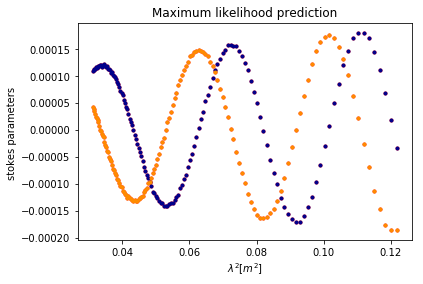

In [82]:
ax = pl.subplot(111)

pl.plot(t1,mu, linestyle='none', marker='.', color = 'red')
pl.plot(t1,mu1, linestyle='none', marker='.', color = 'red')

pl.plot(lam2_R,stokesQ_R, linestyle='none', marker='.', color = 'darkblue')
pl.plot(lam2_R,stokesU_R, linestyle='none', marker='.', color = 'darkorange')

ax.fill_between(t1,mu-std,mu+std, facecolor='lightgray') #, lw=0, interpolate=True)
ax.fill_between(t1,mu1-std1,mu1+std1, facecolor='lightgray')

pl. title('Maximum likelihood prediction')
pl.ylabel('stokes parameters ')
pl.xlabel('$\lambda^2 [m^2]$')

pl.show()

In [56]:
rm_out = np.zeros(len(rmdata))
rm_suc = np.full(len(rmdata), False)

for i in tqdm_notebook(range(0,qudata.shape[0])):
    
    stokesQ_R = qudata[i,::-1,0]
    stokesU_R = qudata[i,::-1,1]
    
    # run optimization:
    p0 = np.array([-15.,-0.,-5.])
    results = op.minimize(nll, p0, method='L-BFGS-B', jac=grad_nll, bounds=bnds, args=(stokesQ_R, stokesU_R, gp)) #
    
    pharr = np.arctan2(stokesU_R,stokesQ_R)
    phase = np.mean(pharr)*180./np.pi
    phsig = np.sign(phase)

    rm_out[i] = phsig*np.pi/np.exp(results.x[2])
    rm_suc[i] = results.success

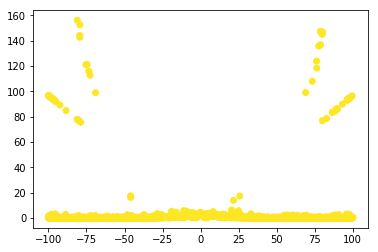

69


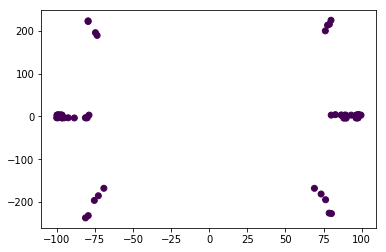

163


In [58]:
pl.subplot(111)
pl.scatter(rmdata,np.abs(np.abs(rmdata)-np.abs(rm_out)),c=rm_suc)
pl.show()
rmdiff = np.abs(np.abs(rmdata)-np.abs(rm_out))
rmdiff2 = rmdiff[np.where(rmdiff>20)]
print(len(rmdiff2))
pl.subplot(111)
pl.scatter(rmdata[np.where(rmdiff>20)],rm_out[np.where(rmdiff>20)],c=rm_suc[np.where(rmdiff>20)])
pl.show()
print(np.argmax(rmdiff))

In [83]:
# set the loglikelihood:
def lnlike(p, x, y1, y2):
 
    ln_a = p[0]
    ln_c = p[1]      
    ln_p = p[2]  

    p0 = np.array([ln_a,ln_c,ln_p])
 
    # update kernel parameters:
    gp.set_parameter_vector(p0)
 
    # calculate the likelihood:
    ll1 = gp.log_likelihood(y1)
    ll2 = gp.log_likelihood(y2)
    ll = ll1 + ll2
    
    return ll if np.isfinite(ll) else 1e25

In [84]:
# set the logprior
def lnprior(p):
 
    lna = p[0]
    lnc = p[1]
    lnP = p[2]
 
    if (-25.<lna<15.) and (-25.<lnc<15.) and (-15<lnP<15.):    
        return 0.0
 
    return -np.inf

In [85]:
# set the logposterior:
def lnprob(p, x, y1, y2):
 
    lp = lnprior(p)
 
    return lp + lnlike(p, x, y1, y2) if np.isfinite(lp) else -np.inf

In [86]:
x_train = lam2_R
y_1 = stokesQ_R
y_2 = stokesU_R

data = (x_train,y_1,y_2)

In [87]:
p = gp.get_parameter_vector()

initial = np.array([p[0],p[1],p[2]])
print("Initial guesses: ",initial)
 
# initial log(likelihood):
init_logL = gp.log_likelihood(y_1) + gp.log_likelihood(y_2)
 
# set the dimension of the prior volume
# (i.e. how many parameters do you have?)
ndim = len(initial)
print("Number of parameters: ",ndim)
 
nwalkers = 32
 
p0 = [np.array(initial) + 1e-5 * np.random.randn(ndim)
      for i in range(nwalkers)]

# initalise the sampler:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

Initial guesses:  [-15.55655217  -0.207348    -4.32463989]
Number of parameters:  3


In [88]:
# run a few samples as a burn-in:
print("Running burn-in")
p0, lnp, _ = sampler.run_mcmc(p0, 500)
sampler.reset()
 
print("Finished Burn-In")

Running burn-in
Finished Burn-In


In [89]:
# take the highest likelihood point from the burn-in as a
# starting point and now begin your production run:
print("Running production")
p = p0[np.argmax(lnp)]
p0 = [p + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
p0, lnp, _ = sampler.run_mcmc(p0, 5000)
 
print("Finished Production")

Running production
Finished Production


In [90]:
# Find the maximum likelihood values:
ml = p0[np.argmax(lnp)]
print("Maximum likelihood parameters: ",np.exp(ml))
print("Period: ",np.pi/np.exp(ml[2])," rad/m^2")

Maximum likelihood parameters:  [1.47296733e-08 3.25996253e-01 3.88657195e-02]
Period:  80.83196948355216  rad/m^2


In [91]:
MLlnB = ml[0]
MLlnC = ml[1]
MLlnP = ml[2]

In [92]:
p = np.array([MLlnB,MLlnC,MLlnP])
gp.set_parameter_vector(p)
ml_logL = gp.log_likelihood(y_1) + gp.log_likelihood(y_2)
print("ML logL:", ml_logL)

ML logL: 3088.3438265208756


In [93]:
gp.set_parameter_vector(p) #initially it was s, p works well

mu, cov = gp.predict(y_1, t1) #return_cov=False)
std = np.sqrt(np.diag(cov))

mu1, cov1 = gp.predict(y_2, t1) #return_cov=False)
std1 = np.sqrt(np.diag(cov1))

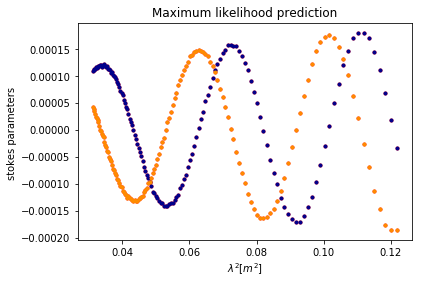

In [94]:
ax = pl.subplot(111)

pl.plot(t1,mu, linestyle='none', marker='.', color = 'red')
pl.plot(t1,mu1, linestyle='none', marker='.', color = 'red')

pl.plot(lam2_R,stokesQ_R, linestyle='none', marker='.', color = 'darkblue')
pl.plot(lam2_R,stokesU_R, linestyle='none', marker='.', color = 'darkorange')

ax.fill_between(t1,mu-std,mu+std, facecolor='lightgray') #, lw=0, interpolate=True)
ax.fill_between(t1,mu1-std1,mu1+std1, facecolor='lightgray')

pl. title('Maximum likelihood prediction')
pl.ylabel('stokes parameters ')
pl.xlabel('$\lambda^2 [m^2]$')

pl.show()

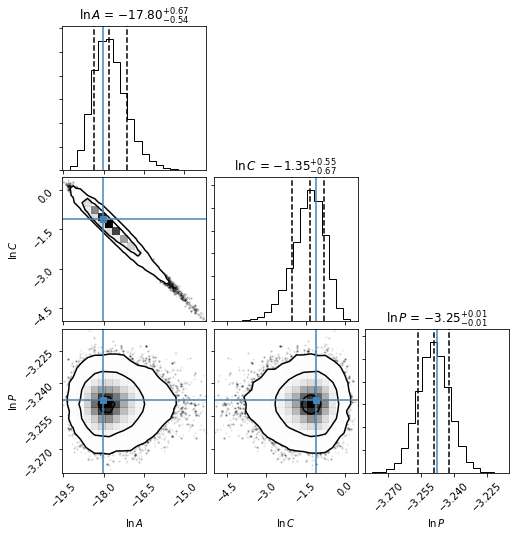

In [95]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
#samples = sampler.flatchain

figure = corner.corner(samples, labels=[r"$\ln\,A$", r"$\ln\,C$", r"$\ln\,P$"],
                         truths=ml,
                         quantiles=[0.16,0.5,0.84],
                         levels=[0.19,0.86,0.99],
                         title="Faraday Thin",
                         show_titles=True, title_args={"fontsize": 10})

---

Calculate information criteria:

In [34]:
def calc_BIC(L,K,N):
    
    bic = -2.*L + K*np.log(N)
    
    return bic

In [35]:
def calc_AIC(L,K):
    
    aic = 2.*K - 2.*L
    
    return aic

In [36]:
def calc_AICc(L,K,N):
    
    aic = calc_AIC(L,K)
    aicc= aic - 2.*K*(K+1)/(N - K - 1)
    
    return aicc

In [37]:
print("BIC : ",calc_BIC(ml_logL,ndim,2*len(lam2_R)))
print("AIC : ",calc_AIC(ml_logL,ndim))
print("AICc: ",calc_AICc(ml_logL,ndim,2*len(lam2_R)))

BIC :  -6246.088879980551
AIC :  -6256.884145857546
AICc:  -6256.9743714214555
